# Loading the Data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import deap
from scipy.spatial import distance_matrix

import array
import random
import json
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from copy import deepcopy

from functools import partial
from operator import attrgetter

from __future__ import division

import multiprocessing
import time

import itertools

random.seed(169)

In [2]:
data_dir = './data/'
problem_files = sorted(os.listdir(data_dir))
input_filename = data_dir+problem_files[0]
print("reading data from",input_filename)

reading data from ./data/C101.txt


In [3]:
input_file = open(input_filename)
all_lines = input_file.readlines()
problem_name=all_lines[0]
max_vehicles = int(all_lines[4].split()[0])
capacity = int(all_lines[4].split()[1])

data = np.loadtxt(input_filename,skiprows=8)
request_data = pd.DataFrame(data,dtype=int,columns=['id','x','y','demand','tw_start','tw_end','service_time'])
request_data.set_index('id', inplace=True)
request_data

,x,y,demand,tw_start,tw_end,service_time
id,,,,,,
0,40,50,0,0,1236,0
1,45,68,10,912,967,90
2,45,70,30,825,870,90
3,42,66,10,65,146,90
4,42,68,10,727,782,90
...,...,...,...,...,...,...
96,60,80,10,95,156,90
97,60,85,30,561,622,90
98,58,75,20,30,84,90


In [4]:
# the time window for the depot (request 0) indicates the total scheduling period
start_time = request_data.loc[0]['tw_start']
end_time = request_data.loc[0]['tw_end']

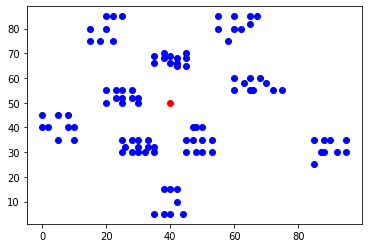

In [5]:
plt.scatter(request_data['x'][0],request_data['y'][0],c='red')
plt.scatter(request_data['x'][1:],request_data['y'][1:],c='blue')
plt.show()

In [6]:
dist_mat = distance_matrix(request_data[['x','y']], request_data[['x','y']])
pd.DataFrame(dist_mat, index=request_data.index, columns=request_data.index)


id,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,18.681542,20.615528,16.124515,18.110770,15.132746,19.000000,16.000000,18.110770,20.099751,...,22.360680,44.204072,43.011626,40.607881,37.202150,36.055513,40.311289,30.805844,33.541020,38.078866
1,18.681542,0.000000,2.000000,3.605551,3.000000,4.242641,5.099020,5.385165,7.000000,7.280110,...,17.000000,27.802878,26.248809,24.413111,20.808652,19.209373,22.671568,14.764823,15.620499,19.723083
2,20.615528,2.000000,0.000000,5.000000,3.605551,5.830952,5.099020,6.403124,7.280110,7.000000,...,18.027756,26.627054,25.000000,23.323808,19.723083,18.027756,21.213203,13.928388,14.142136,18.027756
3,16.124515,3.605551,5.000000,0.000000,2.000000,1.000000,3.605551,2.000000,4.472136,5.656854,...,18.973666,31.400637,29.832868,28.017851,24.413111,22.803509,26.172505,18.357560,19.104973,23.021729
4,18.110770,3.000000,3.605551,2.000000,0.000000,3.000000,2.236068,2.828427,4.000000,4.472136,...,19.697716,30.232433,28.600699,26.925824,23.323808,21.633308,24.758837,17.464249,17.691806,21.400935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,36.055513,19.209373,18.027756,22.803509,21.633308,23.430749,22.825424,24.413111,25.059928,24.166092,...,20.000000,8.602325,7.071068,5.385165,2.000000,0.000000,5.000000,5.385165,5.000000,7.071068
97,40.311289,22.671568,21.213203,26.172505,24.758837,26.907248,25.612497,27.586228,27.802878,26.627054,...,25.000000,7.000000,5.000000,5.830952,5.385165,5.000000,0.000000,10.198039,7.071068,5.000000
98,30.805844,14.764823,13.928388,18.357560,17.464249,18.867962,18.973666,20.124612,21.189620,20.615528,...,15.132746,13.453624,12.206556,9.899495,6.403124,5.385165,10.198039,0.000000,5.830952,10.440307


In [7]:
#example: to get the distance between nodes 0 and 1
dist_mat[0][1]

18.681541692269406

# Visualizing routes/solutions

In [8]:
#example solution
ex_sol = [
    [0,1,4,5,6,0],
    [0,2,3,8,0],
    [0,10,42,0],
    [0,1,2,3,4,5,6,7,8,0]
]

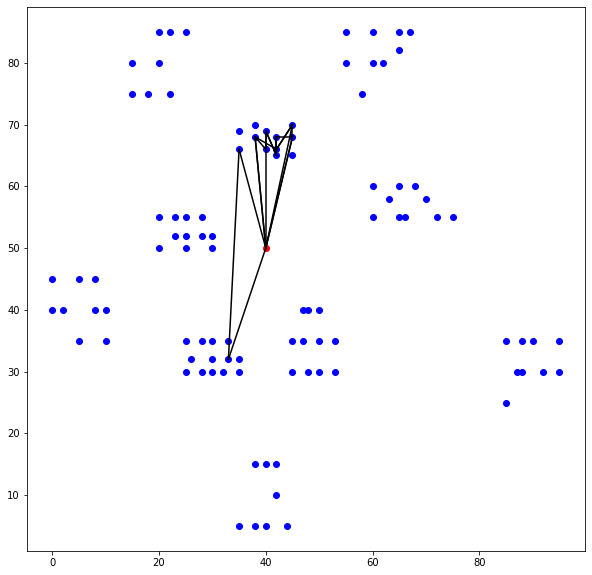

In [9]:
def visualize(sol,data_df):
    plt.figure(figsize=(10,10))
    plt.scatter(data_df['x'][0],data_df['y'][0],c='red')
    plt.scatter(data_df['x'][1:],data_df['y'][1:],c='blue')
    
    for route in sol:
        previous_x=data_df['x'][route[0]]
        previous_y=data_df['y'][route[0]]
        for point in route[1:]:
            current_x=data_df['x'][point]
            current_y=data_df['y'][point]
            
            plt.plot([previous_x,current_x], [previous_y,current_y],c='black')
            
            previous_x=current_x
            previous_y=current_y
        
    plt.show()

visualize(ex_sol,request_data)

# Converting GA chromosomes to Routes

In [10]:
def chromosome2routes_basic(chromosome,verbose=False):
    global start_time
    global end_time
    global dist_mat
    global request_data
    global capacity
    
    #list of routes
    routes=[]
    
    #all routes start at the depot (stop/request 0)
    current_route=[0]
    #number of passengers on the current vehicle
    current_passengers=0
    #elapsed time for the current route
    current_time=start_time
    
    #loop through the requests, in the order specified by the chromosome
    for temp_request in chromosome:
        if verbose : print("adding request ",temp_request)
        #the last served customer on this route
        prev_request=current_route[-1]
        
        #time required to travel from the previous location
        travel_time = dist_mat[prev_request][temp_request]
        
        #if the vehicle arrives early, it must wait till the start of the time window i.e. incurr a time penalty
        tw_start = request_data.loc[temp_request]['tw_start']
        waiting_time = max((tw_start-(current_time+travel_time)),0)
        
        #condition 1:
        #    vehicle capacity must not be exceeded
        passengers=request_data.loc[temp_request]['demand']
        c1 = (current_passengers + passengers ) <= capacity
        if verbose and not(c1) : print("~~~~~adding request would exceed capacity")
        
        #condition 2:
        #    vehicle must arrive at the customer's location before the time window closes
        c2 = (current_time+travel_time)<= request_data.loc[temp_request]['tw_end']
        if verbose and not(c2) : print("~~~~~vehicle cannot arrive within time window")
        
        #condition 3:
        #    vehicle must be able to serve the customer and return to the depot within the scheduling period
        service_time = request_data.loc[temp_request]['service_time']
        c3 = (current_time+travel_time+waiting_time+service_time+dist_mat[temp_request][0])<= end_time
        if verbose and not(c3) : print("~~~~~vehicle would not be able to serve and return to the depot")
        
        #all 3 conditions must be true for the request to be considered feasible to serve
        #if it is feasible to serve this request in the current route, append it
        if (c1 and c2 and c3):
            current_route.append(temp_request)
            current_time+= (travel_time+waiting_time+service_time)
            current_passengers+= passengers
            
        #otherwise, end the current route here, and start a new route with this request    
        else:
            #routes must always end at the depot too
            current_route.append(0)
            routes.append(current_route)
            
            #start a new route
            if verbose : print("Starting a new route")
            current_route=[0,temp_request]
            current_passengers= passengers
            travel_time=dist_mat[0][temp_request]
            waiting_time = max((tw_start-(start_time + travel_time)),0)
            current_time = start_time + travel_time + waiting_time + service_time

    current_route.append(0)
    routes.append(current_route)
    return routes

In [11]:
def chromosome2routes_advanced(chromosome,verbose=False):
    global start_time
    global end_time
    global dist_mat
    global request_data
    global capacity
    
    routes = chromosome2routes_basic(chromosome,verbose)
    
    #TODO : implement this based on Phase 2 of Section 3.7 by Ombuki et. al
    
    return routes
    

In [12]:
#example chromosome
ex_chr = np.arange(1,10)
print(ex_chr)
ex_sol = chromosome2routes_basic(ex_chr,verbose=True)
print(ex_sol)

[1 2 3 4 5 6 7 8 9]
adding request  1
adding request  2
~~~~~vehicle cannot arrive within time window
Starting a new route
adding request  3
~~~~~vehicle cannot arrive within time window
Starting a new route
adding request  4
adding request  5
~~~~~vehicle cannot arrive within time window
Starting a new route
adding request  6
adding request  7
~~~~~vehicle cannot arrive within time window
Starting a new route
adding request  8
adding request  9
[[0, 1, 0], [0, 2, 0], [0, 3, 4, 0], [0, 5, 6, 0], [0, 7, 8, 9, 0]]


In [13]:
def routes2chromosome(routes):
    chromosome = list(itertools.chain(*routes))
    chromosome = [gene for gene in chromosome if gene!=0]
    return creator.Individual(chromosome)

In [14]:
#to test chromosome2routes, we use the best known solution for C101
#and ensure that it is split up properly
#(obtained from http://sun.aei.polsl.pl/~zjc/best-solutions-solomon.html#C101)
c101_sol=[13,17,18,19,15,16,14,12,43,42,41,40,44,46,45,48,51,50,52,49,47,90,87,86,83,82,84,85,88,89,91,67,65,63,62,74,72,61,64,68,66,69,98,96,95,94,92,93,97,100,99,5,3,7,8,10,11,9,6,4,2,1,75,20,24,25,27,29,30,28,26,23,22,21,81,78,76,71,70,73,77,79,80,57,55,54,53,56,58,60,59,32,33,31,35,37,38,39,36,34]
c101_routes=chromosome2routes_basic(c101_sol)
c101_routes

[[0, 13, 17, 18, 19, 15, 16, 14, 12, 0],
 [0, 43, 42, 41, 40, 44, 46, 45, 48, 51, 50, 52, 49, 47, 0],
 [0, 90, 87, 86, 83, 82, 84, 85, 88, 89, 91, 0],
 [0, 67, 65, 63, 62, 74, 72, 61, 64, 68, 66, 69, 0],
 [0, 98, 96, 95, 94, 92, 93, 97, 100, 99, 0],
 [0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 75, 0],
 [0, 20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21, 0],
 [0, 81, 78, 76, 71, 70, 73, 77, 79, 80, 0],
 [0, 57, 55, 54, 53, 56, 58, 60, 59, 0],
 [0, 32, 33, 31, 35, 37, 38, 39, 36, 34, 0]]

# Fitness function

In [15]:
def getRouteDistance(route):
    global dist_mat
    distance=0
    for i in range(1,len(route)):
        distance += dist_mat[route[i-1]][route[i]]
    return distance

def getTotalDistance(routes):
    distance=0
    for route in routes:
        distance += getRouteDistance(route)
    return distance

In [16]:
def getChromosomeFitness(chromosome,verbose=False):
    routes=chromosome2routes_advanced(chromosome,verbose)
    
    #objective 1:
    #    minimize total distance travelled
    obj1=getTotalDistance(routes)
    
    #objective 2:
    #    minimize number of vehicles required (i.e number of routes)
    obj2=len(routes)
    
    return obj1,obj2

In [17]:
#Once again confirming correctness using the known solution
c101_dist,c101_vehicles = getChromosomeFitness(c101_sol)
print("Total travel distance : ",c101_dist)
print("Vehicles Required : ",c101_vehicles)

Total travel distance :  828.9368669428338
Vehicles Required :  10


# Selection Function

In [18]:
#based on tools.selTournament
def selCustom_basic(individuals, k,fit_attr="fitness"):

    #as specified by the paper
    tournsize=4
    r_thresh=0.8
    
    chosen = []
    for i in range(k):
        aspirants = tools.selRandom(individuals, tournsize)
        if random.random() < r_thresh :
            chosen_individual=max(aspirants, key=attrgetter(fit_attr))
        else:
            chosen_individual = tools.selRandom(aspirants, 1)[0]
        chosen.append(chosen_individual)
    return chosen

In [19]:
def selCustom_pareto(individuals, k):
    
    #using DEAP's sortNondominated, we get a list of fronts,
    #where each front 'i' dominates front 'i+1'.
    #we use this to create a new attribute for each individual, called "rank"
    #the rank is then used as the fitness value for the tournament selection,
    #as specified by Ombuki et. al
    pareto_fronts = tools.sortNondominated(individuals, k)
    for front_rank in range(1,len(pareto_fronts)+1):
        front=pareto_fronts[front_rank-1]
        for ind in front:
            setattr(ind, 'rank', front_rank)
    
    #as specified by the paper
    tournsize=4
    r_thresh=0.8
    
    chosen = []
    for i in range(k):
        aspirants = tools.selRandom(individuals, tournsize)
        if random.random() < r_thresh :
            chosen_individual=min(aspirants, key=attrgetter("rank"))
        else:
            chosen_individual = tools.selRandom(aspirants, 1)[0]
        chosen.append(chosen_individual)
    return chosen    
    

In [20]:
def selCustom_pareto_elitist(individuals, k):
    
    
    #using DEAP's sortNondominated, we get a list of fronts,
    #where each front 'i' dominates front 'i+1'.
    #we use this to create a new attribute for each individual, called "rank"
    #the rank is then used as the fitness value for the tournament selection,
    #as specified by Ombuki et. al
    pareto_fronts = tools.sortNondominated(individuals, k)
    for front_rank in range(1,len(pareto_fronts)+1):
        front=pareto_fronts[front_rank-1]
        for ind in front:
            setattr(ind, 'rank', front_rank)
            
    #the first rank is the "elite" (Pareto-optimal) set of solutions
    #to which we want to guarantee a spot in the next generation
    #therefore, we extract them before the tournament selection takes place
    elite = pareto_fronts.pop(0)
    individuals_excluding_elite = [i for i in individuals if i not in elite]
    #we update k, the number of individuals to be chosen by the tournament selection
    k-=len(elite)
    
    #as specified by the paper
    tournsize=4
    r_thresh=0.8
    
    chosen = []
    for i in range(k):
        aspirants = tools.selRandom(individuals_excluding_elite, tournsize)
        if random.random() < r_thresh :
            chosen_individual=min(aspirants, key=attrgetter("rank"))
        else:
            chosen_individual = tools.selRandom(aspirants, 1)[0]
        chosen.append(chosen_individual)
    
    #add in the elite solutions
    chosen+=elite
    return chosen    
    

In [21]:
elite=[0,1,6]
chosen=[2,4,8]
chosen+=elite
[i for i in [0,23,4,6,7] if i not in elite]

[23, 4, 7]

# Crossover Function

In [22]:
t = [0,1,2,3,4,5]
possible_insertion_points=range(1,len(t))
possible_t=[]
for ins in possible_insertion_points:
    temp_t=deepcopy(t)
    temp_t.insert(ins,10)
    possible_t.append(temp_t)
possible_t

[[0, 10, 1, 2, 3, 4, 5],
 [0, 1, 10, 2, 3, 4, 5],
 [0, 1, 2, 10, 3, 4, 5],
 [0, 1, 2, 3, 10, 4, 5],
 [0, 1, 2, 3, 4, 10, 5]]

In [23]:
def removeRequest(routes,request):
    for route in routes:
        if request in route: 
            #if the route only contains the request we are trying to remove,
            #remove it entirely
            if len(route)<=3:
                routes.remove(route)
            #otherwise, just remove the request from the route
            else:
                route.remove(request)
                
    return routes

def isFeasible(route):
    global start_time
    global end_time
    global dist_mat
    global request_data
    global capacity
    
    #this is just a sanity check...the code shouldn't even be generating such routes
    if ((route[0]!=0) or (route[-1]!=0)): return False
    
    current_time=start_time
    current_passengers=0
    
    for i in range(1,len(route)-1):
        temp_request=route[i]
        #the last served customer on this route
        prev_request=route[i-1]
        
        #time required to travel from the previous location
        travel_time = dist_mat[prev_request][temp_request]
        #if the vehicle arrives early, it must wait till the start of the time window i.e. incurr a time penalty
        tw_start = request_data.loc[temp_request]['tw_start']
        waiting_time = max((tw_start-(current_time+travel_time)),0)
        #time required to serve the current request
        service_time = request_data.loc[temp_request]['service_time']
        
        #demand of the current request
        passengers=request_data.loc[temp_request]['demand']
        
        #update the time taken and vehicle capacity
        current_time+= (travel_time+waiting_time+service_time)
        current_passengers+= passengers
        
        #consider route infeasible if AT LEAST ONE of the following is true:
        #    1. the vehicle capacity has been exceeded
        #    2. the vehicle cannot reach the next request before its time window closes
        c1=current_passengers>capacity
        next_request=route[i+1]
        c2=(current_time + dist_mat[temp_request][next_request]) > request_data.loc[next_request]['tw_end']
        if (c1 or c2) : return False
        
    return True

def insertRequest_firstFit(routes,request):
    
    #try to find the first feasible insertion point
    for route in routes:
        possible_insertion_points=range(1,len(route))
        for ins_index in possible_insertion_points:
            candidate_route=deepcopy(route)
            candidate_route.insert(ins_index,request)
            if isFeasible(candidate_root):
                route=deepcopy(candidate_route)
                return routes             
              
    #if we get to here, no feasible insertion point was found, so we have to create a new route
    additional_route=[0,request,0]
    routes.append(additional_route)
    return routes

def insertRequest_bestFit(routes,request):
    
    candidate_solutions = []
    
    #loop through the routes in the solution
    for route_index in range(0,len(routes)):
        current_route = routes[i]
        
        #for this route, get all possible locations where the new request could be inserted
        possible_insertion_points=range(1,len(current_route))        
        #loop through the possible modifications for this route 
        for ins_index in possible_insertion_points:
            
            #take a copy of the route, and insert the new request at "ins_index"
            candidate_route=deepcopy(current_route)
            candidate_route.insert(ins_index,request)           
            #check if the rew route would still be feasible
            if isFeasible(candidate_root):                
                #create a copy of the entire list of routes
                candidate_sol=deepcopy(routes)
                #replace the old route with the new one (with the request inserted into it)
                candidate_sol[route_index]=deepcopy(candidate_route)
                #store the solution with the inserted request
                candidate_solutions.append(candidate_sol)
    
    #if we found at least one feasible solution, pick the best one 
    if len(candidate_solutions)>0:
        #work out the distance travelled for each of the candidate solutions
        candidate_distances = [ getTotalDistance(sol) for sol in candidate_solutions]
        #pick the best candidate solution (i.e the one which minimizes the distance travelled)
        routes=candidate_solutions[np.argmin(candidate_distances)]
            
    #if we didn't, just create a new route with "request" in it and append it to the old solution
    else:
        routes.append([0,request,0])
    
    return routes
        
        
        
def cxCustom(ind1,ind2):
    ind1_routes = chromosome2routes_advanced(ind1)
    ind2_routes = chromosome2routes_advanced(ind2)
    
    #pick a random route from the other chromosome
    remove_from_ind2 = random.sample(ind1_routes,1)
    #remove the leading and trailing 0 (ie travelling to/from depot)
    remove_from_ind2 = remove_from_ind2[1:-1]
    #repeat for the other chromosome
    remove_from_ind1 = random.sample(ind2_routes,1)
    remove_from_ind1 = remove_from_ind1[1:-1]    
    
    #remove the chosen requests from their original place
    for r in remove_from_ind2 : 
        ind2_routes = removeRequest(ind2_routes,r)
    #the removed requests should be re-inserted in a random order
    random.shuffle(remove_from_ind2)
    #re-insert the removed requests
    for r in remove_from_ind2 :
        ind2_routes = insertRequest_bestFit(ind2_routes,r)
        
    #repeat for the other chromosome
    for r in remove_from_ind1 : 
        ind1_routes = removeRequest(ind1_routes,r)   
    random.shuffle(remove_from_ind1)
    for r in remove_from_ind1 :
        ind1_routes = insertRequest_bestFit(ind1_routes,r)
        
    return routes2chromosome(ind1_routes), routes2chromosome(ind2_routes)

In [24]:
l=[4,97,1,34,56,1]
np.argmin(l)

2

# Mutation Function

In [25]:
test=[0,1,2,3,4,5,6,7,8]
flip_start=2
flip_end=5
to_flip=test[flip_start:flip_end+1]
to_flip.reverse()
test=test[:flip_start]+to_flip+test[flip_end+1:]
test

[0, 1, 5, 4, 3, 2, 6, 7, 8]

In [26]:
def mutCustom(individual):
    
    flip_length = random.choice([2,3])
    flip_start = random.randint(0,(len(individual)-flip_length))
    flip_end = flip_start + (flip_length-1)
    to_flip=individual[flip_start:flip_end+1]
    to_flip.reverse()
    individual=individual[:flip_start]+to_flip+individual[flip_end+1:]
    individual=creator.Individual(individual)
    
    return individual,


In [27]:
#ensuring that the mutation happens inside a single route
def mutCustom_singleRoute(individual):
    routes = chromosome2routes_advanced(individual)
    
    #to undergo mutation, a route must visit at least 2 requests
    eligible_route_index=[ i for i in range(0,len(routes)) if len(routes[i])>=4]
    
    if len(eligible_route_index)>0:
        #randomly choose a route to mutate
        chosen_route_index=random.choice(eligible_route_index)
        chosen_route=routes[chosen_route_index]
        #the length of the flip is either 2 or 3 requests, if the route is long enough
        flip_length_max = 3 if len(chosen_route)>=5 else 2
        #when working with the routes (not the individual),
        #we must ensure that we don't flip the leading/trailing zeros by mistake
        flip_length = random.choice([2,flip_length_max])
        flip_start = random.randint(0,(len(chosen_route)-1-flip_length))
        flip_end = flip_start + (flip_length-1)
        to_flip=chosen_route[flip_start:flip_end+1]
        to_flip.reverse()
        chosen_route=chosen_route[:flip_start]+to_flip+chosen_route[flip_end+1:]
        routes[chosen_route_index]=chosen_route
        individual=routes2chromosome(routes)
        individual=creator.Individual(individual)        
    
    return individual,

# Population Initialization

In [28]:
#if "x" has at least 1 neighbor within "radius", this function returns
# the id of that request.
#if x does not have any neighbors, it reurns -1
def getNearestNeighbor(x,remaining,radius):
    global dist_mat
    
    closest_pt=remaining[0]
    min_dist=dist_mat[x][closest_pt]
    for r in remaining[1:]:
        r_dist=dist_mat[x][r]
        if r_dist<=min_dist:
            closest_pt=r
            min_dist=r_dist
    
    if (min_dist<=radius):
        return closest_pt
    else :
        return -1

In [33]:
def generateGreedyPop(n,radius=10):
    global request_data
    
    greedy_pop=[]
    for i in range(0,n):
        C=list(request_data.index[1:])
        l=[]

        #pick a random request, and move it to the chromosome
        req=random.choice(C)
        l.append(req)
        C.remove(req)
        
        #repeat until the list of requests
        #to order is empty
        while C:
            req=getNearestNeighbor(req,C,radius)
            #if no neighbors were found, pick another random starting point
            if (req==-1):
                req=random.choice(C)
            l.append(req)
            C.remove(req)            
        
        greedy_pop.append(creator.Individual(l))
    
    return greedy_pop

In [39]:
#fine-tuning the radius parameter
p_size=500
for r in [5,10,15,20,25,30,40]:
    print("generating %d greedy solutions using a neighborhood radius of %d"%(p_size,r))
    pop=generateGreedyPop(p_size,r)
    fitnesses=np.array([getChromosomeFitness(c) for c in pop])
    print("mean :",np.mean(fitnesses,axis=0))
    print("best :",np.min(fitnesses,axis=0))

generating 500 greedy solutions using a neighborhood radius of 5
mean : [3610.55869293   51.422     ]
best : [2386.22474589   35.        ]
generating 500 greedy solutions using a neighborhood radius of 10
mean : [3471.64670904   52.326     ]
best : [2147.48185036   36.        ]
generating 500 greedy solutions using a neighborhood radius of 15
mean : [3373.39876294   50.914     ]
best : [1948.13506464   34.        ]
generating 500 greedy solutions using a neighborhood radius of 20
mean : [3260.10106163   49.904     ]
best : [2114.64903925   34.        ]
generating 500 greedy solutions using a neighborhood radius of 25
mean : [3254.47438157   50.254     ]
best : [2148.10214651   33.        ]
generating 500 greedy solutions using a neighborhood radius of 30
mean : [3235.06377334   50.08      ]
best : [1952.66791338   33.        ]
generating 500 greedy solutions using a neighborhood radius of 40
mean : [3115.31244425   48.96      ]
best : [2086.94928271   36.        ]


# Configuring the GA

In [30]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))

#we specify that the individuals shall be of type "array"
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator
requests_to_order=request_data.index[1:]
toolbox.register("indices", random.sample, list(requests_to_order), len(requests_to_order))

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", cxCustom)
toolbox.register("mutate", mutCustom_singleRoute)
toolbox.register("select", selCustom_pareto_elitist)
toolbox.register("evaluate", getChromosomeFitness)

pop_size=300
greedy_ratio=0.5
random_pop = toolbox.population(n=int(pop_size*(1-greedy_ratio)))
greedy_pop=generateGreedyPop(n=int(pop_size*greedy_ratio))
pop=random_pop+greedy_pop

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean,axis=0)
#stats.register("std", np.std,axis=0)
stats.register("min", np.min,axis=0)
#stats.register("max", np.max,axis=0)

In [31]:
start = time.time()

out_pop,out_stats = algorithms.eaSimple(pop,
                                toolbox,
                                cxpb=0.8,#crossover probability
                                mutpb=0.1,#mutation probability
                                ngen=10,#number of generations
                                stats=stats,
                                halloffame=hof)

end = time.time()
print("Execution Time :",end-start)

gen	nevals	avg                          	min                          
0  	300   	[4191.18470174   54.22333333]	[2038.07122304   31.        ]
1  	255   	[3569.31264494   49.95333333]	[2038.07122304   31.        ]
2  	244   	[2981.5251891   44.59     ]  	[2038.07122304   31.        ]
3  	251   	[2632.18147843   40.77      ]	[2038.07122304   31.        ]
4  	249   	[2399.05623191   38.47333333]	[2038.07122304   31.        ]
5  	250   	[2296.61390006   37.00666667]	[2118.53244512   32.        ]
6  	249   	[2291.48545224   35.44666667]	[2118.53244512   32.        ]
7  	246   	[2312.76587779   33.96333333]	[2118.53244512   32.        ]
8  	253   	[2322.1864113   33.35     ]  	[2118.53244512   32.        ]
9  	241   	[2326.90653353   33.24      ]	[2118.53244512   32.        ]
10 	248   	[2317.77699416   33.32666667]	[2118.53244512   32.        ]
Execution Time : 188.08825278282166


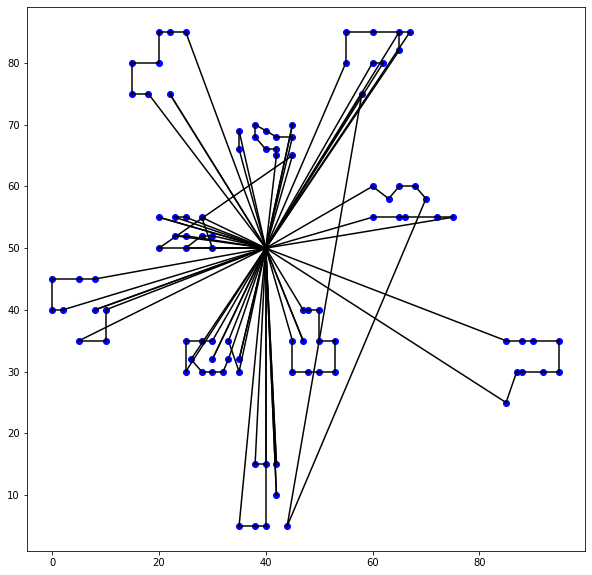

31
2038.0712230350896


In [32]:
best=hof[0]
best_route=chromosome2routes_basic(best)
visualize(best_route,request_data)
print(len(best_route))
print(getTotalDistance(best_route))